In [35]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from catboost import CatBoostClassifier, Pool
import random 
import seaborn as sns

from os import listdir
from tqdm import tqdm
from os.path import isfile

import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

import warnings
warnings.filterwarnings("ignore")

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)
print()
print("lightgbm:", lgb.__version__)
print("xgboost:", xgb.__version__)
print("catboost:", cb.__version__)


pandas: 0.24.2
numpy: 1.16.1
sklearn: 0.19.1

lightgbm: 2.3.0
xgboost: 0.80
catboost: 0.16.5


In [2]:
train = pd.read_csv('./TRAIN_PREPARED.csv')
train, val = train.iloc[:160000], train.iloc[160000:]
test  = pd.read_csv('./TEST_PREPARED.csv')

In [3]:
y = train.label.values
y_val = val.label.values

train = train.drop(['user', 'label'], axis=1)
val   = val.drop(['user', 'label'], axis=1)
test  = test.drop('user', axis=1)

In [4]:
# Lets play with some dates
def date2columns(data, date_col, suf):
    data['Date'] = pd.to_datetime(pd.Series(data[date_col]))
    data = data.drop(date_col, axis=1)

    data[suf+'Year'] = data['Date'].apply(lambda x: int(str(x)[:4]))
    data[suf+'Month'] = data['Date'].apply(lambda x: int(str(x)[5:7]))
    data[suf+'weekday'] = data['Date'].dt.dayofweek
    
    data = data.drop('Date', axis=1)
    return data

In [5]:
train = date2columns(train, 'cut_date', 'cut_')
train = date2columns(train, 'first_date', 'first_')
train = date2columns(train, 'last_date', 'last_')

val = date2columns(val, 'cut_date', 'cut_')
val = date2columns(val, 'first_date', 'first_')
val = date2columns(val, 'last_date', 'last_')

test = date2columns(test, 'cut_date', 'cut_')
test = date2columns(test, 'first_date', 'first_')
test = date2columns(test, 'last_date', 'last_')

In [6]:
train = train.fillna(-1)
val   = val.fillna(-1)
test = test.fillna(-1)

for f in tqdm(train.columns):
    if train[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + 
                list(val[f].values) +
                list(test[f].values))
        
        train[f] = lbl.transform(list(train[f].values))
        val[f] = lbl.transform(list(val[f].values))
        test[f] = lbl.transform(list(test[f].values))
        
# train-test discrepancy analysis is skipped

100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 4055.29it/s]


In [7]:
cols = list(train.columns)
len(cols), cols

(150,
 ['days_to_end',
  'num_country_max_1days',
  'num_city_max_1days',
  'android_max_1days',
  'smarttv_max_1days',
  'iphone_max_1days',
  'ipad_max_1days',
  'apple_max_1days',
  'pc_max_1days',
  'time_spent_sum_3days',
  'time_spent_max_3days',
  'num_title_ep_sum_3days',
  'num_title_ep_max_3days',
  'num_title_ru_sum_3days',
  'num_title_ru_max_3days',
  'num_country_max_3days',
  'num_city_max_3days',
  'other_content_sum_3days',
  'top_1_sum_3days',
  'top_2_sum_3days',
  'top_3_sum_3days',
  'top_4_sum_3days',
  'top_5_sum_3days',
  'top_6_sum_3days',
  'top_7_sum_3days',
  'top_8_sum_3days',
  'top_9_sum_3days',
  'top_10_sum_3days',
  'android_max_3days',
  'smarttv_max_3days',
  'iphone_max_3days',
  'ipad_max_3days',
  'apple_max_3days',
  'pc_max_3days',
  'time_spent_sum_7days',
  'time_spent_max_7days',
  'num_title_ep_sum_7days',
  'num_title_ep_max_7days',
  'num_title_ru_sum_7days',
  'num_title_ru_max_7days',
  'num_country_max_7days',
  'num_city_max_7days',
  

In [8]:
scaler = StandardScaler() #MinMaxScaler StandardScaler RobustScaler

train[cols] = scaler.fit_transform(train[cols])
val[cols] = scaler.transform(val[cols])
test[cols] = scaler.transform(test[cols])

In [9]:
N = 35

svd = TruncatedSVD(n_components=N, random_state=42)
X = svd.fit_transform(train[cols], y)
X_val = svd.transform(val[cols])
X_test = svd.transform(test[cols])
svd.explained_variance_ratio_.sum()

0.84199869443301

In [10]:
print(len(X), len(y), len(X_val), len(y_val))

160000 160000 20249 20249


In [11]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "nei"

train[arch] = 0
#test[arch] = 0

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = X[train_index]
    X_valid = X[valid_index]

    y_train = y[train_index]
    y_valid = y[valid_index]
    
    nei = KNeighborsClassifier(n_neighbors=2,
                               p=1, n_jobs=-1).fit(X_train, y_train) 
    
    y_pred = nei.predict_proba(X_valid)[:,1]
    
    train.loc[valid_index, arch] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))
    
test[arch] = nei.predict_proba(X_test)[:,1]
val[arch]  = nei.predict_proba(X_val)[:, 1]

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

0 ROC AUC: 0.9081
1 ROC AUC: 0.91132
2 ROC AUC: 0.90754
3 ROC AUC: 0.90473
4 ROC AUC: 0.91114

OOF ROC AUC: 0.90856

Wall time: 5min 55s


In [12]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "rfc"

train[arch] = 0

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = X[train_index]
    X_valid = X[valid_index]

    y_train = y[train_index]
    y_valid = y[valid_index]
    
    rfc = RandomForestClassifier(n_estimators=150,
                                 criterion='gini',
                                 n_jobs=-1).fit(X_train, y_train) 
    
    y_pred = rfc.predict_proba(X_valid)[:,1]
    train.loc[valid_index, arch] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))

test[arch] = rfc.predict_proba(X_test)[:,1]
val[arch]  = rfc.predict_proba(X_val)[:, 1]

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

0 ROC AUC: 0.92359
1 ROC AUC: 0.92281
2 ROC AUC: 0.92264
3 ROC AUC: 0.92558
4 ROC AUC: 0.92385

OOF ROC AUC: 0.92369

Wall time: 3min 29s


In [13]:
%%time

arch = "lgb"

train[arch] = 0

rounds = 10000
early_stop_rounds = 300

params = {'objective': 'binary',
          'boosting_type': 'gbrt',
          'metric': 'auc',
          'seed': 42,
          'max_depth': 8,
          'leraning_rate': 0.05,
          'bagging_freq': 1,
          'bagging_fraction': 0.9,
          'bagging_seed': 42,
          'verbose': -1,
          'n_jobs': -1}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = X[train_index]
    X_valid = X[valid_index]

    y_train = y[train_index]
    y_valid = y[valid_index]

    d_train = lgb.Dataset(X_train, y_train)
    d_valid = lgb.Dataset(X_valid, y_valid)    

    model = lgb.train(params,
                      d_train,
                      num_boost_round=rounds,
                      valid_sets=[d_train, d_valid],
                      valid_names=['train','valid'],
                      early_stopping_rounds=early_stop_rounds,
                      verbose_eval=0) 

    joblib.dump(model, "./output/lgb_"+str(i)+".pkl")

    y_pred = model.predict(X_valid)
    train.loc[valid_index, arch] = y_pred
    auc = roc_auc_score(y_valid, y_pred)
    print(i, "ROC AUC:", round(auc, 5))

test[arch] = model.predict(X_test)
val[arch]  = model.predict(X_val)

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

0 ROC AUC: 0.91523
1 ROC AUC: 0.91995
2 ROC AUC: 0.91846
3 ROC AUC: 0.92162
4 ROC AUC: 0.92053

OOF ROC AUC: 0.91909

Wall time: 15min 21s


In [15]:
%%time

arch = "cat"

train[arch] = 0

rounds = 10000
early_stop_rounds = 100

params = {'task_type': 'GPU', #GPU
          'iterations': rounds,
          'loss_function': 'Logloss',
          'eval_metric':'AUC',
          'random_seed': 42,
          'learning_rate': 0.02,
          'depth': 9}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = X[train_index]
    X_valid = X[valid_index]

    y_train = y[train_index]
    y_valid = y[valid_index]
    
    trn_data = Pool(X_train, y_train)
    val_data = Pool(X_valid, y_valid)
    
    clf = CatBoostClassifier(**params)
    clf.fit(trn_data,
            eval_set=val_data,
            use_best_model=True,
            early_stopping_rounds=early_stop_rounds,
            verbose=0)
    
    y_pred = clf.predict_proba(X_valid)[:, 1]
    train.loc[valid_index, arch] = y_pred
    auc = roc_auc_score(y_valid, y_pred)
    print(i, "ROC AUC:", round(auc, 5))

test[arch] = clf.predict_proba(X_test)[:,1]
val[arch]  = clf.predict_proba(X_val)[:, 1]

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

0 ROC AUC: 0.92703
1 ROC AUC: 0.92829
2 ROC AUC: 0.92786
3 ROC AUC: 0.93126
4 ROC AUC: 0.93189

OOF ROC AUC: 0.92926

Wall time: 18min 58s


In [36]:
models = ["cat", "nei", "rfc", "lgb"]

train[models].corr()

,cat,nei,rfc,lgb
cat,1.000000,0.775267,0.917605,0.948069
nei,0.775267,1.000000,0.752849,0.754732
rfc,0.917605,0.752849,1.000000,0.898531
lgb,0.948069,0.754732,0.898531,1.000000


In [18]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "stack"

train[arch] = 0

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train = train.loc[train_index, models]
    X_valid = train.loc[valid_index, models]

    y_train = y[train_index]
    y_valid = y[valid_index]
    
    reg = LogisticRegression(C=1,
                             solver="newton-cg", 
                             penalty="l2", 
                             n_jobs=-1, 
                             max_iter=100).fit(X_train, y_train) 
    
    y_pred = reg.predict_proba(X_valid)[:,1]
    train.loc[valid_index, arch] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))
    
test[arch] = reg.predict_proba(test[models])[:, 1]
val[arch]  = reg.predict_proba(val[models])[:, 1]

print()
print("OOF ROC AUC:", round(roc_auc_score(y, train[arch]), 5))
print()

0 ROC AUC: 0.95469
1 ROC AUC: 0.95528
2 ROC AUC: 0.95296
3 ROC AUC: 0.95429
4 ROC AUC: 0.95687

OOF ROC AUC: 0.95479

Wall time: 8.14 s


In [37]:
print('Coefs:', reg.coef_[0]/np.sum(reg.coef_[0])*100)
print('Validation score:', round(roc_auc_score(y_val, val['stack']), 5))

Coefs: [30.89891505 27.74102466 34.71556724  6.64449306]
Validation score: 0.95551


C:\Users\narek\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


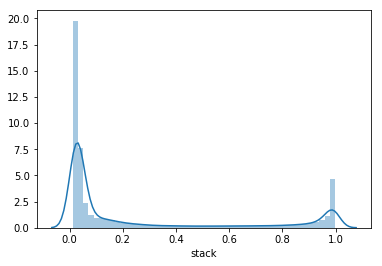

In [34]:
sns.distplot(train['stack'])

C:\Users\narek\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


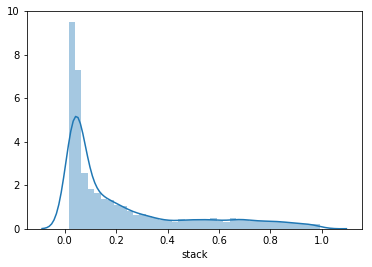

In [25]:
sns.distplot(test['stack'])

In [27]:
submit = pd.read_csv('./test_submit_example.csv')
submit['prediction'] = test['stack']
submit.head()

In [32]:
submit.to_csv('./submission.csv')